<a href="https://colab.research.google.com/github/chettkulkarni/datasharing/blob/master/Alterus_Vera_Stance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stance detection Factor

**Stance** is the way in which speakers position themselves in relation to the ongoing interaction, in terms of evaluation, intentionality, epistemology or social relations.

Hence in the pursuit to find out about the stance of the news can actually help us determine if the news is fake or not



To detect Stance we are going to use 2 different datasets 


1.   SemEval Dataset : Which has Tweets Data and Stance associated with the tweets

    *   [Link to Dataset](http://alt.qcri.org/semeval2016/task6/data/uploads/stancedataset.zip)

    *   [Info about Dataset](http://alt.qcri.org/semeval2016/)



2.   Fake News Challenge : Which has dataset news and stance associated with tweets 
    * [Link to Dataset](https://www.kaggle.com/ad6398/stance-detection/download)
    * [Info about Dataset](http://www.fakenewschallenge.org/)




# Idea

The whole idea of stance detection is based on following prediction



```
Similar Statements tend to have Similar Stance
```



# Approach

1. Get All the data from both the datasets
2. Remove the unwanted columns 
3. Remove Digits
4. Perform Stemming the words
5. Remove Stop Words
6. Remove Punctuation marks
7. Update the Stance of SemEval Dataset to the following values
    *  'AGAINST' to 1
    *  'FAVOR' to 2
    *  'NONE' to 0
8. Update the Stance of FakeNewsChallenge Datset to the following  values
    * 'unrelated' to 0
    * 'disagree' to 1
    * 'agree' to 2
    * 'discuss' to 3
9. Combine Both the dataset
10. Create Tagged Document
11. Create a doc2Vec Model
12. Using the doc2vec Model get similar document to liar liar dataset
13. Use that information to capture the stance of the statement




# Importing required Libraries for the process

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install nltk
!pip install gensim
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
import numpy as np
import pandas as pd
import nltk
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
import urllib
% matplotlib inline

In [0]:
pd.set_option('display.max_colwidth', -1)

# Downloading all the dataset required
1. Liar Dataset (u need to be logged in sjsu domain to get the file using the code below)
2. Fake News Challenge Dataset ( u need to be logged in sjsu domain to get the file using the code below)
3. Sem2Eval Dataset

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
link = ' https://drive.google.com/open?id=1y3yYF5HHPhH7SyaPwPU9H5HApJzevsFK'
fluff, id = link.split('=')


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('liar.zip')

import zipfile
with zipfile.ZipFile('liar.zip', 'r') as zip_ref:
    zip_ref.extractall()

liar = pd.read_csv('train.tsv', sep='\t',header=None)
liar=liar.drop(columns=[0])

columns=[
'label',
'statement',
'subject',
'speaker',
'speaker_job_title',
'state info',
'party affiliation',
'barely_true_counts',
'false_counts',
'half_true_counts',
'mostly_true_counts',
'pants_on_fire_counts',
'context'
]


liar.columns=columns

liar.head()

,label,statement,subject,speaker,speaker_job_title,state info,party affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,half-true,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,false,Health care reform legislation is likely to mandate free sex change surgeries.,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,half-true,The economic turnaround started at the end of my term.,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [0]:
link = ' https://drive.google.com/open?id=1R92GzZsujQFyCYGCWY45zeE5G4KKVhGR'
fluff, id = link.split('=')


#Download the file
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('stance-detection.zip')

#unzip the downloaded file
import zipfile
with zipfile.ZipFile('stance-detection.zip', 'r') as zip_ref:
    zip_ref.extractall()

#read the file and store it in dataframe called fake , this is the data set found from fake news challenge website
fake=pd.read_csv('train_merged.csv',encoding='latin-1')
fake=fake.drop(columns=['Body ID','Headline' ])
fake=fake.drop_duplicates()

In [8]:
#seeing some of the records
fake.head()

,articleBody,Stance
0,"A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports. \r\n\r\nGovernment spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a ""relatively small"" meteorite that ""appears to have come off an asteroid that was passing close to Earth."" House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. \r\nMurillo said Nicaragua will ask international experts to help local scientists in understanding what happened.\r\n\r\nThe crater left by the meteorite had a radius of 39 feet and a depth of 16 feet, said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee. He said it is still not clear if the meteorite disintegrated or was buried.\r\n\r\nHumberto Garcia, of the Astronomy Center at the National Autonomous University of Nicaragua, said the meteorite could be related to an asteroid that was forecast to pass by the planet Saturday night.\r\n\r\n""We have to study it more because it could be ice or rock,"" he said.\r\n\r\nWilfried Strauch, an adviser to the Institute of Territorial Studies, said it was ""very strange that no one reported a streak of light. We have to ask if anyone has a photo or something.""\r\n\r\nLocal residents reported hearing a loud boom Saturday night, but said they didn't see anything strange in the sky.\r\n\r\n""I was sitting on my porch and I saw nothing, then all of a sudden I heard a large blast. We thought it was a bomb because we felt an expansive wave,"" Jorge Santamaria told The Associated Press.\r\n\r\nThe site of the crater is near Managua's international airport and an air force base. Only journalists from state media were allowed to visit it.",unrelated
24,"A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports. \r\n\r\nGovernment spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a ""relatively small"" meteorite that ""appears to have come off an asteroid that was passing close to Earth."" House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. \r\nMurillo said Nicaragua will ask international experts to help local scientists in understanding what happened.\r\n\r\nThe crater left by the meteorite had a radius of 39 feet and a depth of 16 feet, said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee. He said it is still not clear if the meteorite disintegrated or was buried.\r\n\r\nHumberto Garcia, of the Astronomy Center at the National Autonomous University of Nicaragua, said the meteorite could be related to an asteroid that was forecast to pass by the planet Saturday night.\r\n\r\n""We have to study it more because it could be ice or rock,"" he said.\r\n\r\nWilfried Strauch, an adviser to the Institute of Territorial Studies, said it was ""very strange that no one reported a streak of light. We have to ask if anyone has a photo or something.""\r\n\r\nLocal residents reported hearing a loud boom Saturday night, but said they didn't see anything strange in the sky.\r\n\r\n""I was sitting on my porch and I saw nothing, then all of a sudden I heard a large blast. We thought it was a bomb because we felt an expansive wave,"" Jorge Santamaria told The Associated Press.\r\n\r\nThe site of the crater is near Managua's international airport and an air force base. Only journalists from state media were allowed to visit it.",agree
36,"Last week we hinted at wh

In [0]:
#downloading the file from sem2eval and unzipping and loading it into df

url='http://alt.qcri.org/semeval2016/task6/data/uploads/stancedataset.zip'
urllib.request.urlretrieve(url, 'stancedataset.zip')

with zipfile.ZipFile('stancedataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

df=pd.read_csv('StanceDataset/train.csv', sep=',',header=0, error_bad_lines=False,encoding= 'unicode_escape',engine='python')
df=df[['Tweet','Stance']]

In [12]:
df

,Tweet,Stance
0,"@tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot",AGAINST
1,Hillary is our best choice if we truly want to continue being a progressive nation. #Ohio,FAVOR
2,"@TheView I think our country is ready for a female pres, it can't ever be Hillary",AGAINST
3,I just gave an unhealthy amount of my hard-earned money away to the big gov't & untrustworthy IRS. #WhyImNotVotingForHillary,AGAINST
4,@PortiaABoulger Thank you for adding me to your list,NONE
...,...,...
2909,"There's a law protecting unborn eagles, but not humans uh, idk if you've noticed, but there aren't 7 billion eagles around. #SemST",AGAINST
2910,I am 1 in 3... I have had an abortion #AbortionOnDemand #MenstruationMatters #SemST,AGAINST
2911,"How dare you say my sexual preference is a choice, how dare you say dismembering my preborn isn't. #liberalism #SemST",AGAINST
2912,"Equal rights for those 'born that way', no rights for those not yet born. #LiberalLogic #liberalism #life #SemST",AGAINST


# Cleaning Data


In [0]:
#defining a set of stop_words, we will be dropping these stop words because they dont give any value to our analysis
stop_words = set(stopwords.words('english')) 

In [0]:
# removing punctation ,special characters and digits and converting all the text to lowe and then work_tokenizing them and storing it in a column called CleanTweet
df['CleanTweet'] = df['Tweet'].map(lambda x: re.sub(r"\W", " ",str(x)))
df['CleanTweet'] = df['CleanTweet'].map(lambda x: re.sub(r'[,\.!?]', " ",str(x)))
df['CleanTweet'] = df['CleanTweet'].map(lambda x: re.sub(r" \d+", " ",str(x)))
df['CleanTweet'] = df['CleanTweet'].map(lambda x: word_tokenize(x.lower()))

df['CleanTweet'] = df['CleanTweet'].map(lambda x: ' '.join(x))
df['CleanTweet'] = df['CleanTweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


In [15]:
df.head()

,Tweet,Stance,CleanTweet
0,"@tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot",AGAINST,tedcruz handovertheserver wiped clean k deleted emails explains dereliction duty lies benghazi etc tcot
1,Hillary is our best choice if we truly want to continue being a progressive nation. #Ohio,FAVOR,hillary best choice truly want continue progressive nation ohio
2,"@TheView I think our country is ready for a female pres, it can't ever be Hillary",AGAINST,theview think country ready female pres ever hillary
3,I just gave an unhealthy amount of my hard-earned money away to the big gov't & untrustworthy IRS. #WhyImNotVotingForHillary,AGAINST,gave unhealthy amount hard earned money away big gov untrustworthy irs whyimnotvotingforhillary
4,@PortiaABoulger Thank you for adding me to your list,NONE,portiaaboulger thank adding list


In [0]:

#A function to create numbers for stances
def stacneIt(s):
  if s=='AGAINST':
    return 1
  elif s=='FAVOR':
    return 2
  else:
    return 0

df['Stance_Number']=df['Stance'].map(lambda x: stacneIt(x))

After the cleaning the dataset the following text 

```
ow dare you say my sexual preference is a choice, how dare you say dismembering my preborn isn't. #liberalism #SemST
```
is converted to 



```
dare say sexual preference choice dare say dismembering preborn liberalism semst
```






In [17]:
df

,Tweet,Stance,CleanTweet,Stance_Number
0,"@tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot",AGAINST,tedcruz handovertheserver wiped clean k deleted emails explains dereliction duty lies benghazi etc tcot,1
1,Hillary is our best choice if we truly want to continue being a progressive nation. #Ohio,FAVOR,hillary best choice truly want continue progressive nation ohio,2
2,"@TheView I think our country is ready for a female pres, it can't ever be Hillary",AGAINST,theview think country ready female pres ever hillary,1
3,I just gave an unhealthy amount of my hard-earned money away to the big gov't & untrustworthy IRS. #WhyImNotVotingForHillary,AGAINST,gave unhealthy amount hard earned money away big gov untrustworthy irs whyimnotvotingforhillary,1
4,@PortiaABoulger Thank you for adding me to your list,NONE,portiaaboulger thank adding list,0
...,...,...,...,...
2909,"There's a law protecting unborn eagles, but not humans uh, idk if you've noticed, but there aren't 7 billion eagles around. #SemST",AGAINST,law protecting unborn eagles humans uh idk noticed billion eagles around semst,1
2910,I am 1 in 3... I have had an abortion #AbortionOnDemand #MenstruationMatters #SemST,AGAINST,abortion abortionondemand menstruationmatters semst,1
2911,"How dare you say my sexual preference is a choice, how dare you say dismembering my preborn isn't. #liberalism #SemST",AGAINST,dare say sexual preference choice dare say dismembering preborn liberalism semst,1
2912,"Equal rights for those 'born that way', no rights for those not yet born. #LiberalLogic #liberalism #life #SemST",AGAINST,equal rights born way rights yet born liberallogic liberalism life semst,1


Worcloud of all three stance on tweeter datasets

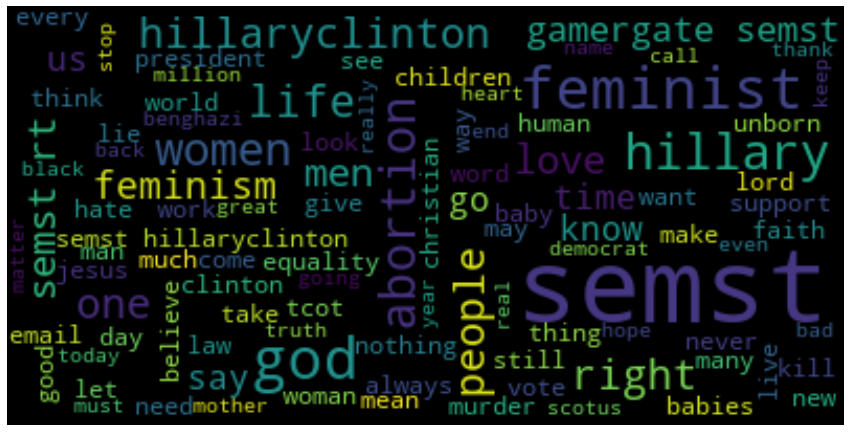

In [18]:
text=' '.join(df[df['Stance']=='AGAINST'].CleanTweet)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

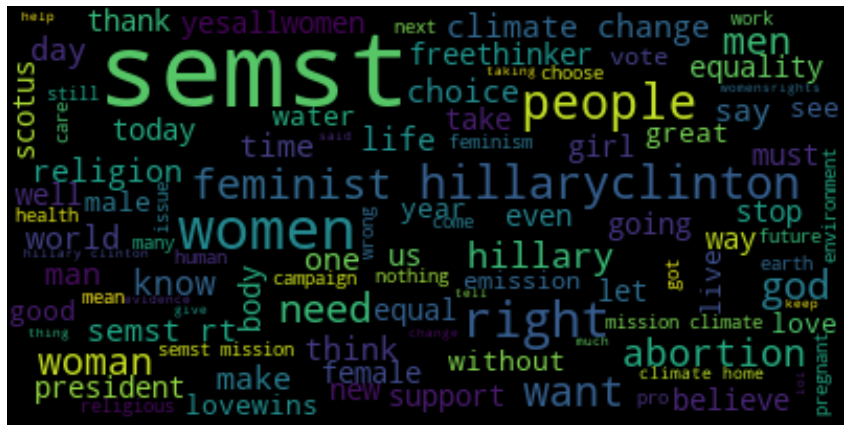

In [19]:
text=' '.join(df[df['Stance']=='FAVOR'].CleanTweet)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

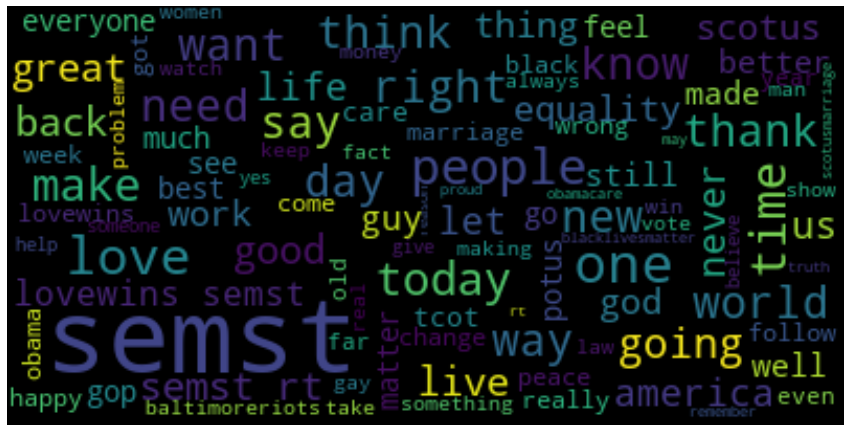

In [20]:
text=' '.join(df[df['Stance']=='NONE'].CleanTweet)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

So Above we have cleaned Tweet and its respective stance

### Data Cleaning on fake news dataset
Performing the similar transformation on fakenews dataset

In [0]:
fake['cleanedArticle'] = fake['articleBody'].map(lambda x: re.sub(r"\W", " ",str(x)))
fake['cleanedArticle'] = fake['cleanedArticle'].map(lambda x: re.sub(r'[,\.!?]', " ",str(x)))
fake['cleanedArticle'] = fake['cleanedArticle'].map(lambda x: re.sub(r" \d+", " ",str(x)))
fake['cleanedArticle'] = fake['cleanedArticle'].map(lambda x: word_tokenize(x.lower()))
fake['cleanedArticle'] = fake['cleanedArticle'].map(lambda x: ' '.join(x))
fake['cleanedArticle'] = fake['cleanedArticle'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [0]:
def getStance(s):
  if s=='agree':
    return 1
  elif s=='disagree':
    return 2
  elif s=='discuss':
    return 3
  else:
    return 0

In [0]:
fake['Stance_Number']=fake['Stance'].map(lambda x: getStance(x))

In [24]:
fake.head(1)

,articleBody,Stance,cleanedArticle,Stance_Number
0,"A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports. \r\n\r\nGovernment spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a ""relatively small"" meteorite that ""appears to have come off an asteroid that was passing close to Earth."" House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. \r\nMurillo said Nicaragua will ask international experts to help local scientists in understanding what happened.\r\n\r\nThe crater left by the meteorite had a radius of 39 feet and a depth of 16 feet, said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee. He said it is still not clear if the meteorite disintegrated or was buried.\r\n\r\nHumberto Garcia, of the Astronomy Center at the National Autonomous University of Nicaragua, said the meteorite could be related to an asteroid that was forecast to pass by the planet Saturday night.\r\n\r\n""We have to study it more because it could be ice or rock,"" he said.\r\n\r\nWilfried Strauch, an adviser to the Institute of Territorial Studies, said it was ""very strange that no one reported a streak of light. We have to ask if anyone has a photo or something.""\r\n\r\nLocal residents reported hearing a loud boom Saturday night, but said they didn't see anything strange in the sky.\r\n\r\n""I was sitting on my porch and I saw nothing, then all of a sudden I heard a large blast. We thought it was a bomb because we felt an expansive wave,"" Jorge Santamaria told The Associated Press.\r\n\r\nThe site of the crater is near Managua's international airport and an air force base. Only journalists from state media were allowed to visit it.",unrelated,small meteorite crashed wooded area nicaragua capital managua overnight government said sunday residents reported hearing mysterious boom left foot deep crater near city airport associated press reports government spokeswoman rosario murillo said committee formed government study event determined relatively small meteorite appears come asteroid passing close earth house sized asteroid rc measured feet diameter skimmed earth weekend abc news reports murillo said nicaragua ask international experts help local scientists understanding happened crater left meteorite radius feet depth feet said humberto saballos volcanologist nicaraguan institute territorial studies committee said still clear meteorite disintegrated buried humberto garcia astronomy center national autonomous university nicaragua said meteorite could related asteroid forecast pass planet saturday night study could ice rock said wilfried strauch adviser institute territorial studies said strange one reported streak light ask anyone photo something local residents reported hearing loud boom saturday night said see anything strange sky sitting porch saw nothing sudden heard large blast thought bomb felt expansive wave jorge santamaria told associated press site crater near managua international airport air force base journalists state media allowed visit,0


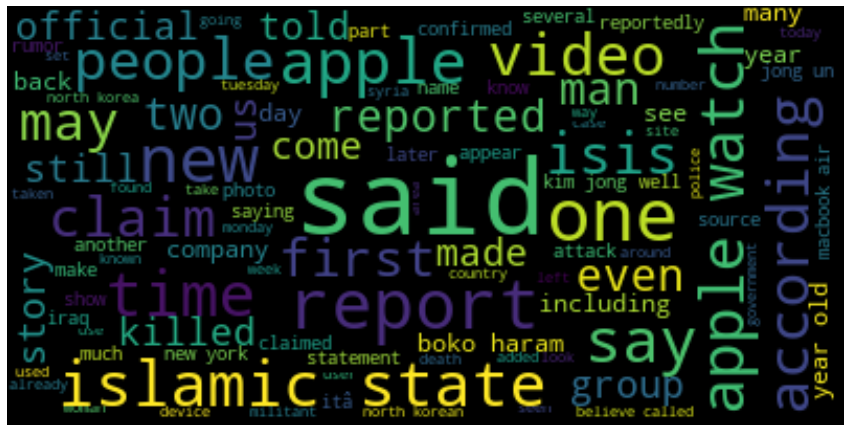

In [25]:
text=' '.join(fake[fake['Stance']=='discuss'].cleanedArticle)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

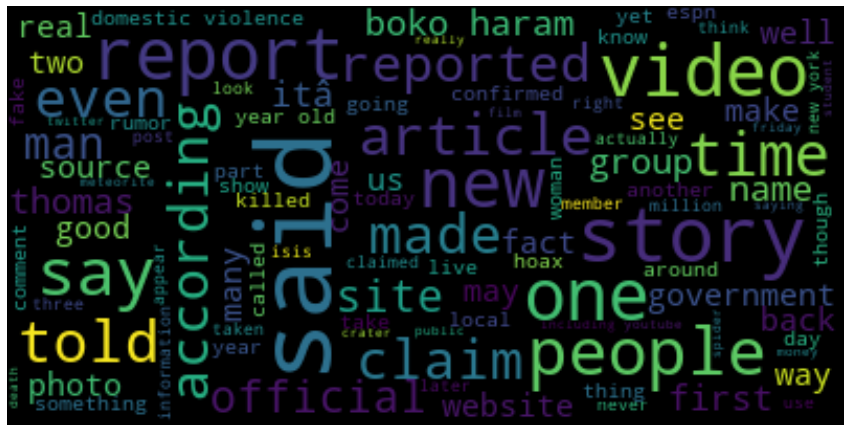

In [26]:
text=' '.join(fake[fake['Stance']=='disagree'].cleanedArticle)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

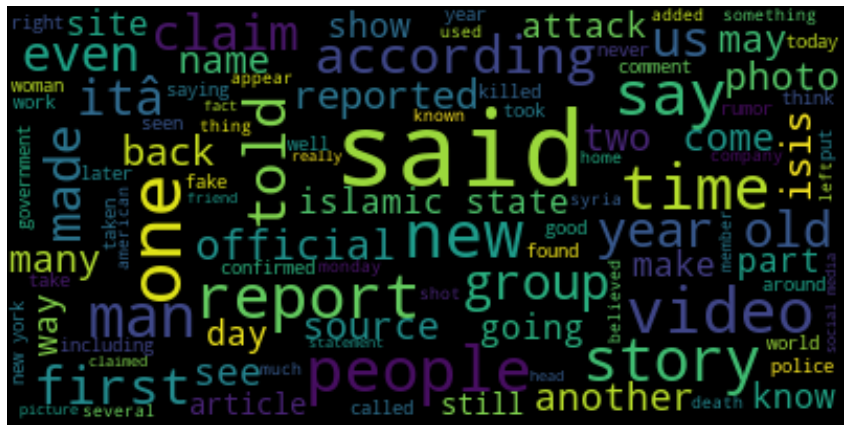

In [27]:
text=' '.join(fake[fake['Stance']=='agree'].cleanedArticle)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

So Above we have cleaned Article and its respective stance

### Combining both the datasets into one to create a doc2vec model

In [0]:
 df1=df[['CleanTweet','Stance_Number']]
 df1.columns=['statement','stance']
 df2=fake[['cleanedArticle','Stance_Number']]
 df2.columns=['statement','stance']

In [0]:
final=pd.concat([df1,df2])

In [30]:
#combined dataset looks like 

final.head()

,statement,stance
0,tedcruz handovertheserver wiped clean k deleted emails explains dereliction duty lies benghazi etc tcot,1
1,hillary best choice truly want continue progressive nation ohio,2
2,theview think country ready female pres ever hillary,1
3,gave unhealthy amount hard earned money away big gov untrustworthy irs whyimnotvotingforhillary,1
4,portiaaboulger thank adding list,0


In [0]:
tagged_data = [TaggedDocument(words=article.split(),tags=[str(index)]) for index, article in enumerate(final['statement'])]

In [32]:
tagged_data[2]

TaggedDocument(words=['theview', 'think', 'country', 'ready', 'female', 'pres', 'ever', 'hillary'], tags=['2'])

# Creating doc2vec model
This model will take the tagged data and will be used on the liar data to find stance of that document

Creating a doc2vec model

This is a model by genism ,which can be used to fin similarity between documents

[Doc2Vec API's](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.WordEmbeddingsKeyedVectors.similarity)

using ba


In [0]:
model = Doc2Vec()
model.build_vocab(tagged_data)
model.train(tagged_data,total_examples=model.corpus_count,epochs=model.iter)

In [0]:
def get_similarity(statement):
  #apply the same cleaning procedure 
  test = re.sub(r"\W", " ",str(statement))
  test =re.sub(r'[,\.!?]', " ",str(test))
  test = re.sub(r" \d+", " ",str(test))
  test= word_tokenize(test.lower())

  #get the vector which can be supplied to doc2vec model
  infered_vector = model.infer_vector(test)

  #using most_similar we will fetch one document in our final stance dataset 
  doc_number , similarity_percentage = model.docvecs.most_similar([infered_vector], topn = 1)[0]
  # print(doc_number , similarity_percentage)
  return doc_number

In [0]:
liar['similar_doc'] = liar['statement'].apply(lambda x: get_similarity(x))

In [0]:
liar['Stance']=liar['similar_doc'].apply(lambda x: final.iloc[int(x)]['stance'])

In [0]:
liar_stances=liar[['statement','Stance']]

In [38]:
liar_stances

,statement,Stance
0,Says the Annies List political group supports third-trimester abortions on demand.,0
1,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,1
2,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",0
3,Health care reform legislation is likely to mandate free sex change surgeries.,1
4,The economic turnaround started at the end of my term.,1
...,...,...
10235,There are a larger number of shark attacks in Florida than there are cases of voter fraud.,3
10236,Democrats have now become the party of the [Atlanta] metro area and of blacks.,1
10237,"Says an alternative to Social Security that operates in Galveston County, Texas, has meant that participants will retire with a whole lot more money than under Social Security.",1
10238,On lifting the U.S. Cuban embargo and allowing travel to Cuba.,1


# Visualisation on stance of liar liar dataset

In [39]:
liar_stances.Stance.value_counts()

1    3629
0    3174
2    1809
3    1628
Name: Stance, dtype: int64

In [0]:
liar_stances_1=liar_stances[liar_stances.Stance==1]
liar_stances_2=liar_stances[liar_stances.Stance==2]
liar_stances_3=liar_stances[liar_stances.Stance==3]
liar_stances_0=liar_stances[liar_stances.Stance==0]

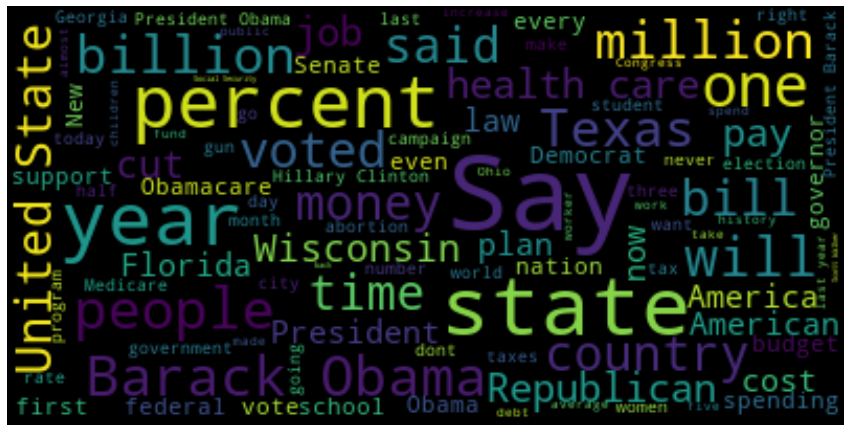

In [41]:
text=' '.join(liar_stances_1.statement)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

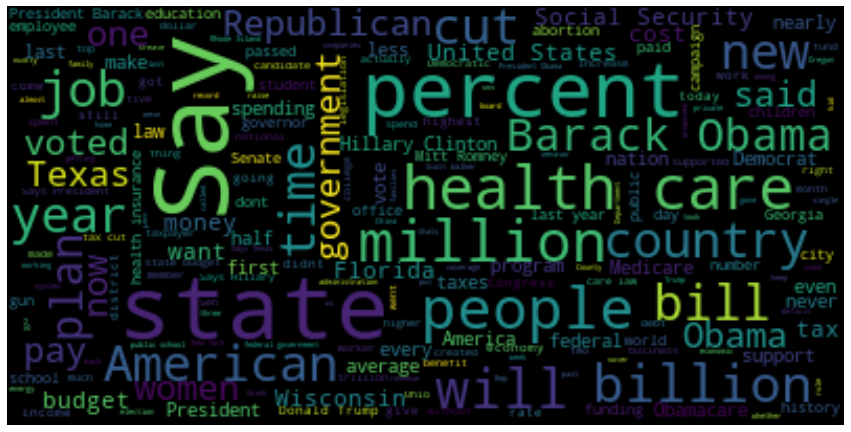

In [42]:
text=' '.join(liar_stances_2.statement)
wordcloud = WordCloud(max_font_size=50, background_color="black").generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

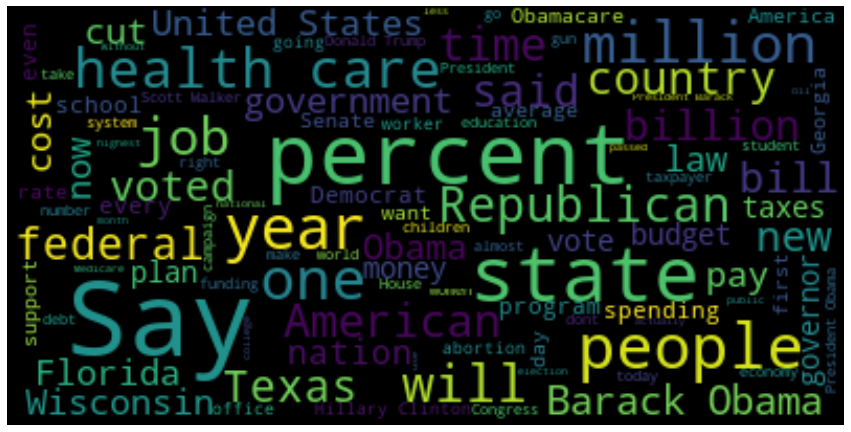

In [43]:
text=' '.join(liar_stances_0.statement)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

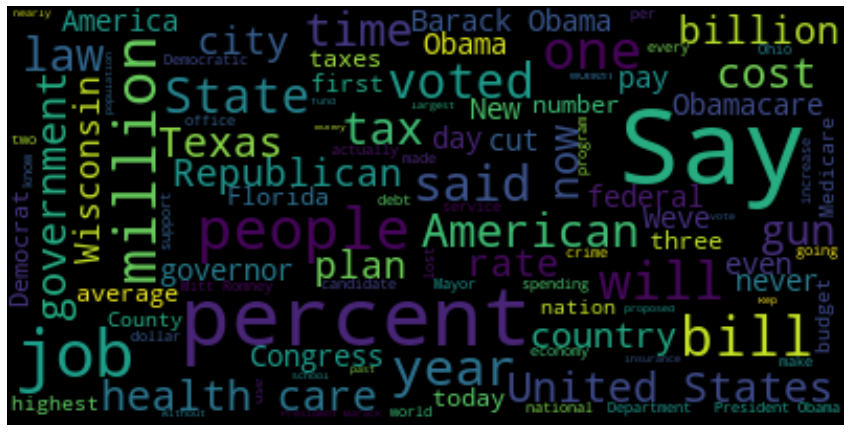

In [44]:
text=' '.join(liar_stances_3.statement)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [0]:
liar.to_csv(r'liar_with_stance.csv')
final.to_csv('final_model_index.csv')
model.save('doc2vec.model')

# Conclusion

With amalgamation of tweeter stances and news stances i have made an attempt to try to capture stance of each statement in news article, with this stance as a metric we hope to find if the news is a fake one or not